# Practical 5 - Dimensionality Reduction with PCA and t-SNE

Names: {Deepak Budha, Shyam Yadav,Shakhzod Bakhodirov}  
Summer Term 2024   

In this practical we will implement dimensionality reduction with PCA, followed by t-SNE. Following is going to be the outline:

 1. Imports
 2. Loading data and related transformations 
 3. PCA without sklearn 
 4. PCA with sklearn and comparison with 3. 
 5. t-SNE with sklearn 

You will be plotting relevant results for visualization and understanding, as you go through the objectives. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context='talk',style='white',palette='colorblind')
import pickle
import matplotlib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy as sp
import scipy.sparse as sp

## Task 0: Load and normalize count data

This practical uses the data set from https://www.nature.com/articles/s41586-018-0654-5. This is single cell transcriptomics data from ~25,000 cells from the cortex. 

For each of these cells, the expression of several thousand genes was measured ```['counts']```. In the original study, the authors were interested in clustering the cells into types. 

We made a selection of 5000 cells and the 1000 most informative genes for run time reasons. We provide you with the original cell type labels determined by the authors for comparison ```['clusters']```.

The following function will apply some preprocessing steps that are standard for transcriptomics data. We normalize the data to bring columns to comparable sizes and log-transform them as they contain huge outliers.

In [2]:
def lognormalize_counts(tasic_dict):

    # normalize and log-transform counts
    counts = tasic_dict['counts']
    
    if sp.issparse(counts):
        counts = counts.todense()  # Convert sparse matrix to dense
        
    libsizes = counts.sum(axis=1)
    CPM = counts / libsizes * 1e+6
    logCPM = np.log2(CPM + 1)
    tasic_dict['logCPM'] = np.array(logCPM)

    return tasic_dict

In [3]:
tasic_1k = lognormalize_counts(pickle.load(open('/kaggle/input/tasic-subset-1kselected/tasic_subset_1kselected.pickle', 'rb')))

/tmp/ipykernel_33/1467658377.py:1: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  tasic_1k = lognormalize_counts(pickle.load(open('/kaggle/input/tasic-subset-1kselected/tasic_subset_1kselected.pickle', 'rb')))


Have a look at ```['counts']```, ```['logCPM']``` and ```['clusters']``` to get a better understanding of the data. Plot a histogram of the cell type labels provided by  ```['clusters']```.

In [128]:
# Extract the relevant data
counts = tasic_1k['counts']
logCPM = tasic_1k['logCPM']
clusters = tasic_1k['clusters']

# Print a summary of the data
print(f"Counts shape: {counts.shape}")
print(f"logCPM shape: {logCPM.shape}")
print(f"Clusters unique labels: {np.unique(clusters)}") 

Counts shape: (5000, 1000)
logCPM shape: (5000, 1000)
Clusters unique labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132]


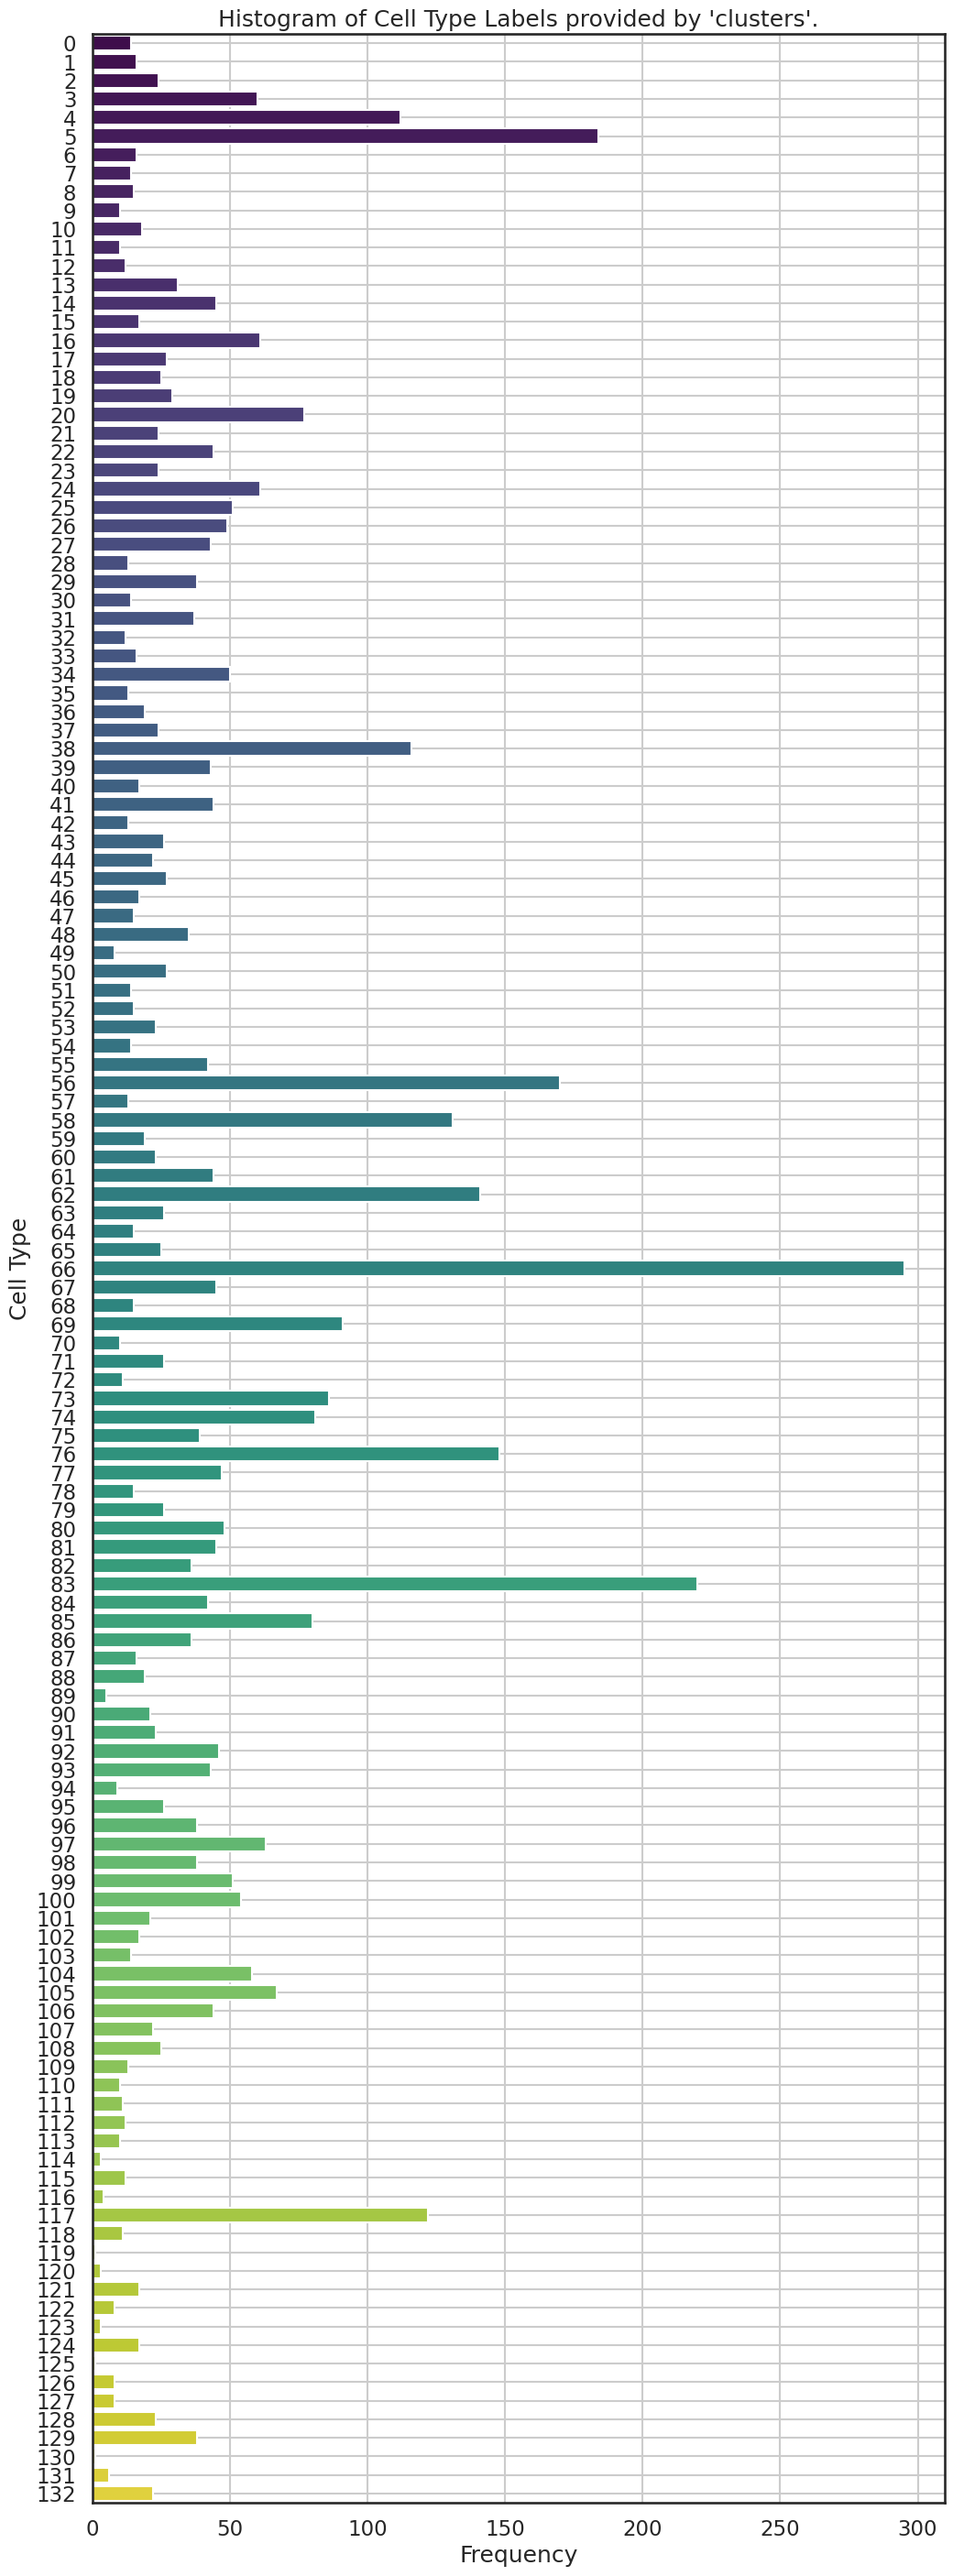

In [18]:
# Plot a histogram of the cell type labels
plt.figure(figsize=(12, 35))
sns.countplot(y=clusters, palette='viridis')
plt.title("Histogram of Cell Type Labels provided by 'clusters'.")
plt.ylabel('Cell Type')
plt.xlabel('Frequency')
plt.grid()

plt.show()

## Task 1: Linear dimensionality reduction with PCA

In this task, you will use Principal Component Analysis (PCA) to reduce the dimensionality of the dataset.

First, implement PCA "by hand". You can use eigenvalue/singular value decomposition from numpy/scipy but no `sklearn`-functions. Write a function that computes all possible principal components and returns them along with the fraction of variance they explain.

In [25]:
import numpy as np

def PCA_manual(data):
    '''
    Function that performs PCA on the input data

    input: (cells, genes)-shaped array of log-transformed cell counts
    output:
        fraction_variance_explained: (genes,)-shaped array with the fraction of variance explained by the individual PCs
        principal_components: (genes, genes)-shaped array containing the principal components as columns
    '''
    ### NOTE: Make sure the function returns the PCs sorted by the fraction of variance explained! ###
    ###       (First column of principal_components should hold the PC with the highest variance   ###
    ###       explained -- fraction_variance_explained should also be sorted accordingly)          ###

    # Center the data by subtracting the mean
    data_mean = np.mean(data, axis=0)
    centered_data = data - data_mean
    
    # Compute the covariance matrix
    covariance_matrix = np.cov(centered_data, rowvar=False)
    
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    # Sort the eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    # Compute the fraction of variance explained by each principal component
    total_variance = np.sum(sorted_eigenvalues)
    fraction_variance_explained = sorted_eigenvalues / total_variance
    
    # Return PCs sorted by the fraction of variance explained
    principal_components = sorted_eigenvectors
    
    return fraction_variance_explained, principal_components


In [26]:
var_expl, PCs = PCA_manual(tasic_1k['logCPM'])

Before we explore the structure of the low-dimensional representation, we first want to know how much variance the first PCs explain: 

- Plot the fraction of variance explained by the `n`-th PC vs. `n`

- Plot the cumulative fraction of variance explained by the first `n` PCs with largest eigenvalue vs. `n`

From the latter plot you should be able to see how many PCs you need to keep to explain at least `x`% of the variance.

How many components do you need to keep to explain 50%, 75%, 90% and 99%, respectively? Indicate this in your plot.

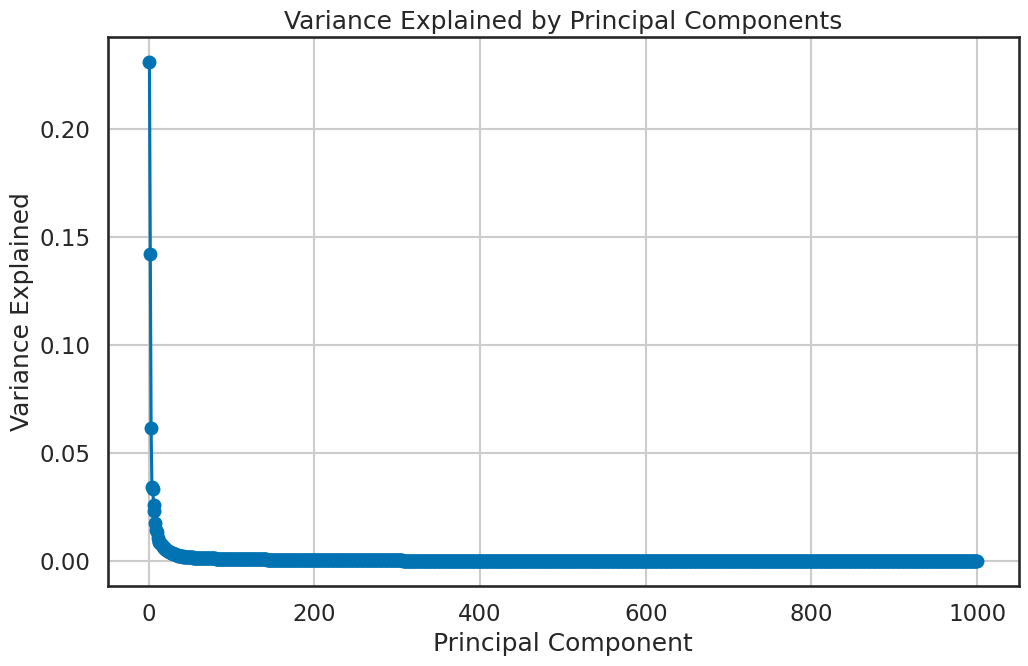

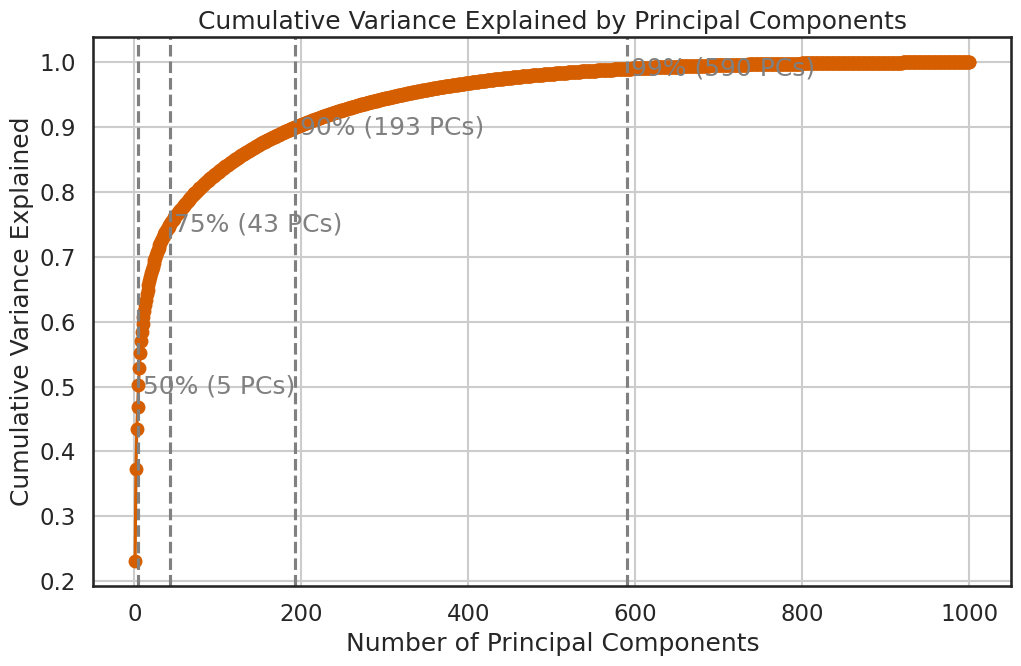

In [39]:
n_PCs = len(var_expl)
PC_ids = np.arange(1, n_PCs+1)

plt.figure(figsize=(20, 7))
plt.subplot(121)

# Plot the variance explained of the n-th PC vs. n
plt.plot(PC_ids, var_expl, marker='o', linestyle='-', color='b')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Principal Components')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the cumulative variance explained for the n PCs with highest variance explained vs. n
# Indicate how many components you need to keep to explain 50%, 75%, 90% and 99% in the plot.

plt.figure(figsize=(20, 7))
plt.subplot(122)

cumulative_variance_explained = np.cumsum(var_expl)
plt.plot(PC_ids, cumulative_variance_explained, marker='o', linestyle='-', color='r')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.grid(True)

# Add horizontal lines indicating thresholds of explained variance
thresholds = [0.5, 0.75, 0.9, 0.99]
for threshold in thresholds:
    n_components = np.argmax(cumulative_variance_explained >= threshold) + 1
    plt.axvline(x=n_components, color='gray', linestyle='--')
    plt.text(n_components + 5, threshold, f'{threshold*100:.0f}% ({n_components} PCs)', va='center', ha='left', color='gray')
    
plt.tight_layout()

plt.show()

From the plot, we can see that we need 5, 43, 193, and 590 prinicpal components to explain 50%, 75%, 90%, and 99% respectively. 

Write a function to select the `n` PCs needed to explain at least `x`% of the variance and use this function to extract as many PCs as are needed to explain 75% of the variance. 

In [41]:
def select_PCs(variance_explained, principal_components, percent_variance=None):
    '''
    Function that selects the first n principal components necessary to explain x% of the variance

    input:
        variance_explained: amount of variance explained by the individual PCs
        principal_components: contains the principal components as columns
        percent_variance: fraction of the variance, the all PCs that are kept explain

    output:
        variance_explained_kept: individual amount of variance explained for the remaining PCs
        principal_components_kept: remaining principal components, shape (genes, n_PCs_kept)
    '''

    # Sort variance explained and principal components by variance explained (descending)
    sorted_indices = np.argsort(variance_explained)[::-1]
    variance_explained_sorted = variance_explained[sorted_indices]
    principal_components_sorted = principal_components[:, sorted_indices]

    # Compute cumulative variance explained
    cumulative_variance_explained = np.cumsum(variance_explained_sorted)

    # Determine the number of components needed to explain at least percent_variance of the variance
    if percent_variance is not None:
        target_variance = percent_variance
        n_components = np.argmax(cumulative_variance_explained >= target_variance) + 1
    else:
        n_components = len(variance_explained)

    # Select the principal components and variance explained up to n_components
    variance_explained_kept = variance_explained_sorted[:n_components]
    principal_components_kept = principal_components_sorted[:, :n_components]

    return variance_explained_kept, principal_components_kept


In [46]:
_, PCs75 = select_PCs(var_expl, PCs, percent_variance=0.75)
print(PCs75.shape)
PCs75

(1000, 43)


array([[-2.86841825e-03, -7.39914177e-03,  4.10942528e-04, ...,
         9.09122538e-05,  2.13829856e-03,  5.44251969e-03],
       [-8.90906786e-04, -2.77466790e-03,  2.59610069e-04, ...,
         8.27735347e-04,  1.03142966e-02,  1.45884764e-03],
       [-2.01183577e-03, -6.23015636e-03,  3.07094456e-04, ...,
         1.72076112e-03,  5.96341915e-03, -5.77499147e-03],
       ...,
       [-3.20559788e-03, -9.33703482e-03,  2.47974148e-04, ...,
        -3.62870001e-03, -3.26969854e-03, -1.48112495e-03],
       [-3.18975833e-03, -9.35593771e-03,  7.35523967e-04, ...,
         1.84682757e-03, -2.85509473e-03,  8.36434053e-03],
       [ 1.92646007e-02,  6.94544486e-02,  7.82303879e-03, ...,
         3.47853932e-03,  2.37969994e-02,  2.40412846e-02]])

To compute the representation of the data in this lower dimensional representation, write a function that compute the PC scores for each cell, i.e. that projects the original data matrix on the low-dimensional subspace provided by the first `n` PCs:

In [48]:
def compute_PCA_scores(data, principal_components):
    '''
    Function that returns the PC scores for each data point

    input:
        data: (cells, genes)-shaped array of log transformed cell counts
        principal_components: contains the principal components as columns

    output:
        pc_scores: (cells, n_PCs_kept)-shaped array of PC scores
    '''

    # Center the data (if not already centered)
    data_centered = data - np.mean(data, axis=0)

    # Compute PC scores by projecting centered data onto principal components
    pc_scores = np.dot(data_centered, principal_components)

    return pc_scores

In [55]:
tasic_1k['PCA_75'] = compute_PCA_scores(tasic_1k['logCPM'], PCs75)
tasic_1k['PCA_75'].shape

(5000, 43)

Visualize the top 5 PCs as a pairwise scatter plot. Use one subplot for each pair of components.

Use the colors provided in `tasic_1k['clusterColors']` and the cluster information in `tasic_1k['clusters']` to color each data point according to its original cluster identity.

The colors indicate the family of the cell type:

- greenish colors: excitatory neurons
- orange colors: somatostatin positive interneurons
- pinkish colors: VIP-positive interneurons
- reddish colors: parvalbumin positive interneurons
- dark colors: non-neurons (glia etc)

What do you observe?

In [124]:
def plot_PCs(data_transformed, color_per_datapoint):
    '''
    Function that plots the scores of the 10 pairs of the top 5 PCs against each other.

    inputs:
        data_transformed: (cells, n_PCs_kept)-shaped array of PC scores
        color_per_datapoint: (cells,)-shaped array of color strings, one color for each cell
    '''
    # Only take the top 5 PCs
    top_pcs = data_transformed[:, :5]

    # Create subplots for pairwise scatter plots
    fig, axes = plt.subplots(5, 2, figsize=(12, 20))  # 5 rows, 2 columns
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    # Define pairs of PCs to plot
    pc_pairs = [(0, 1), (0, 2), (0, 3), (0, 4),
                (1, 2), (1, 3), (1, 4),
                (2, 3), (2, 4),
                (3, 4)]

    # Loop over each pair of PCs
    for idx, (i, j) in enumerate(pc_pairs):
        row = idx // 2
        col = idx % 2

        axes[row, col].scatter(top_pcs[:, i], top_pcs[:, j], 
                               c=color_per_datapoint, s=10, alpha=0.6)
        axes[row, col].set_xlabel(f'PC{i+1}')
        axes[row, col].set_ylabel(f'PC{j+1}')

    plt.show()

# Example usage:
# Assuming data_transformed and color_per_datapoint are defined elsewhere
# plot_PCs(data_transformed, color_per_datapoint)


        

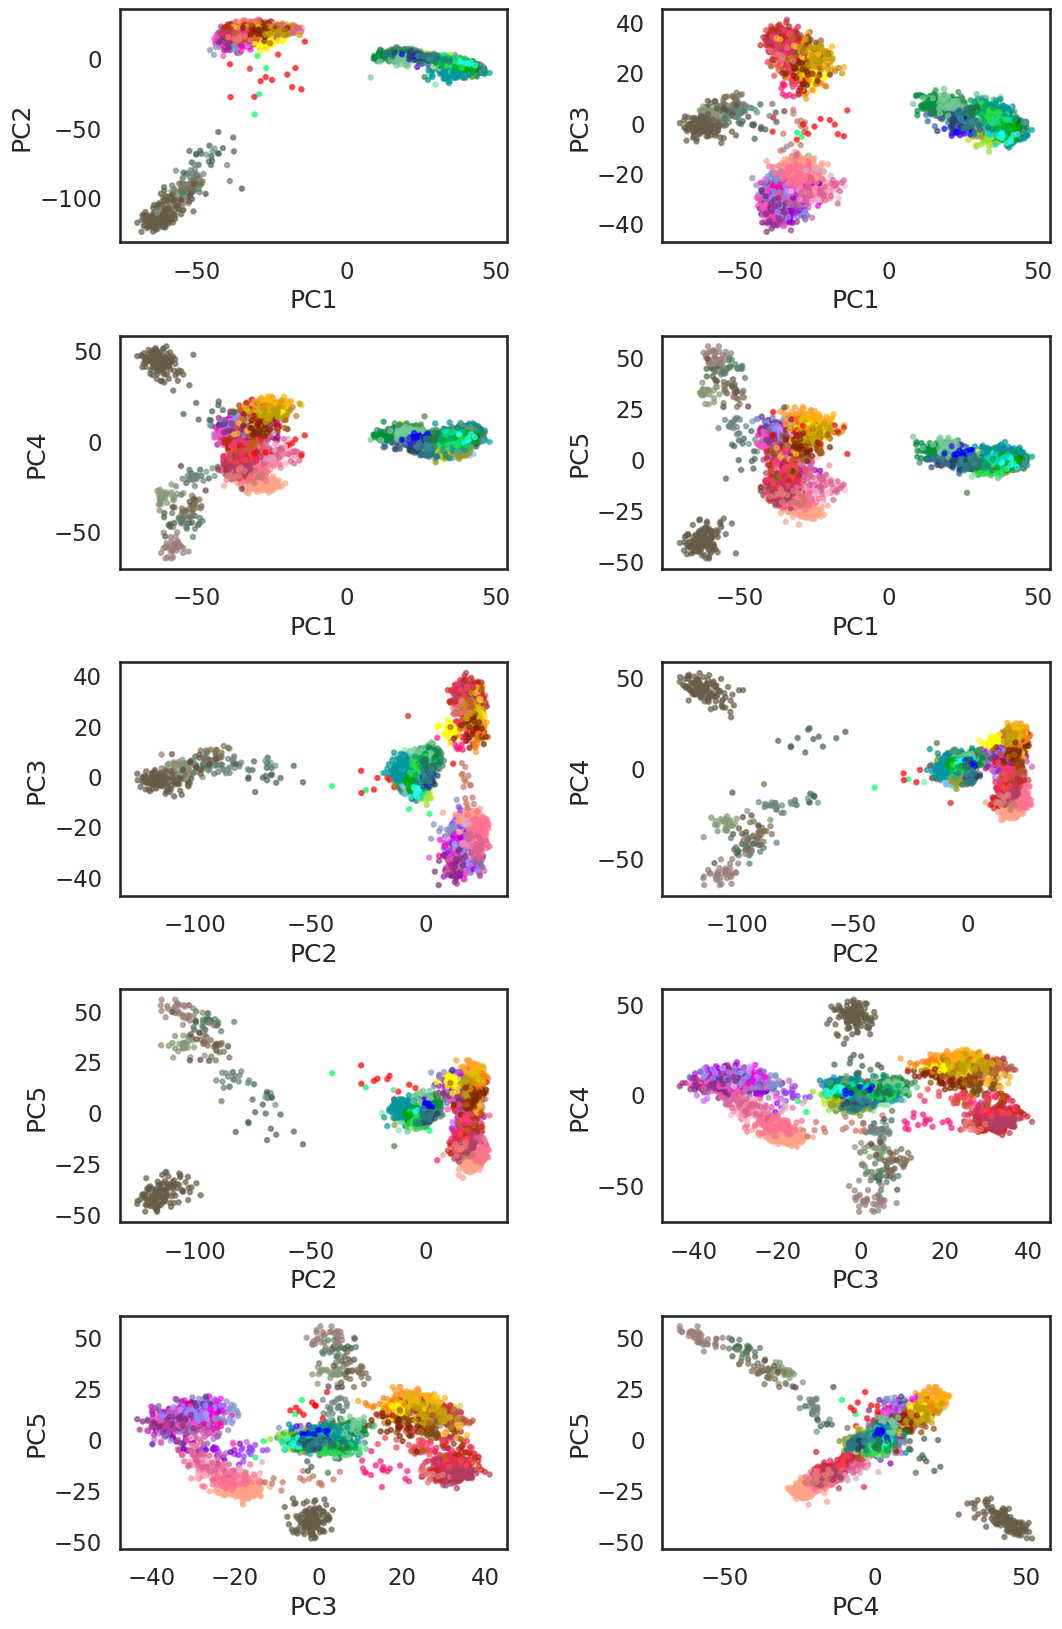

In [125]:
color_per_datapoint = tasic_1k['clusterColors'][tasic_1k['clusters']]
plot_PCs(tasic_1k['PCA_75'], color_per_datapoint)

In [64]:
print(tasic_1k['PCA_75'].shape)
print(color_per_datapoint.shape)

(5000, 43)
(5000,)


- In the plots, we can see that the second pais of the top 5 PCs i.e.(PC1, PC3) are well segregated clusters. We can say that the principle components used in this plot effectively discriminate betweeen different cell types. Thus, the combinations of (PC1, PC3) gives the best visualization of our data.

- If we closely analyse the patterns then we can see that the pairs of initial principal componets best captures the variations in our data. For example, in most of our plots, the clusters are well segregated when the principal components pairs are in the range of PC1, PC2, and so on.

- Also, in the pair (PC4, PC5), we can see that the cluster shows linear pattern. It can indicate that there exists relationships or correlations between the principal components for latter pairs of principal components. 

## Task 2: Comparison with PCA implemented by sklearn

Use the PCA implementation of sklearn to check whether your PCA implementation is correct and obtain some insights into numerical precision of the algorithms underlying PCA implementations. Note that the sklearn implementation of PCA switches the dimensions of the matrix, so you will have to transpose your principal components matrix to get the same output as in the manual implementation.

In [71]:
from sklearn.decomposition import PCA

def PCA_sklearn(data):
    '''
    Function that performs PCA on the input data, using sklearn

    input: (cells, genes)-shaped array of log transformed cell counts
    output:
        fraction_variance_explained: (genes,)-shaped array with the fraction of variance explained by the individual PCs
        principal_components: (genes, genes)-shaped array containing the principal components as columns
    '''

    # Initialize PCA object
    pca = PCA()

    # Fit PCA to the data
    pca.fit(data)

    # Extract fraction of variance explained by each PC
    fraction_variance_explained = pca.explained_variance_ratio_

    # Extract principal components
    principal_components = pca.components_

    # Transpose principal components to match the format (genes, genes)
    principal_components = principal_components.T

    return fraction_variance_explained, principal_components


In [75]:
# do sklearn-PCA on selected genes
var_expl_sklearn, PCs_sklearn = PCA_sklearn(tasic_1k['logCPM'])
# select components as before
_, PCs_sklearn75 = select_PCs(var_expl_sklearn, PCs_sklearn, 0.75)
# get PC scores
PCA_75_sklearn = compute_PCA_scores(tasic_1k['logCPM'], PCs_sklearn75)
print(PCA_75_sklearn.shape)
PCA_75_sklearn

(5000, 43)


array([[-29.83630466,   4.63589764,  -4.84954775, ...,   0.46604663,
         -8.05341688,   2.91983777],
       [-40.53140931,   6.92467397,  -0.8502446 , ...,  -1.56633064,
         -5.8382542 ,  -2.67151536],
       [ 28.56940527, -18.21873863,  24.99909628, ...,  -7.39903382,
          5.52792848,  -1.50441016],
       ...,
       [ 50.95849323,  90.74618262,  -6.99571305, ..., -11.38104784,
         18.10815626,  -2.59470457],
       [ 58.13768932,  97.93058838,  -8.57625823, ..., -10.85328119,
         22.69231292,  -3.94993588],
       [ 52.41384152,  99.26509624,  -3.65794317, ...,  -5.3853237 ,
         20.77433175,  -4.37890655]])

To see if your manual PCA yielded the same PC weights as the sklearn PCA, we can just take the two matrices of principal components and plot their entries against each other. (Note: This again assumes they are sorted by variance explained and the order of dimensions in your weight matrix compared to the sklearn weight matrix is the same (change if necessary).)

Use the following plot to compare the results to your own implementation (here plotting the weights of the first 100 PCs against each other). What do you observe?

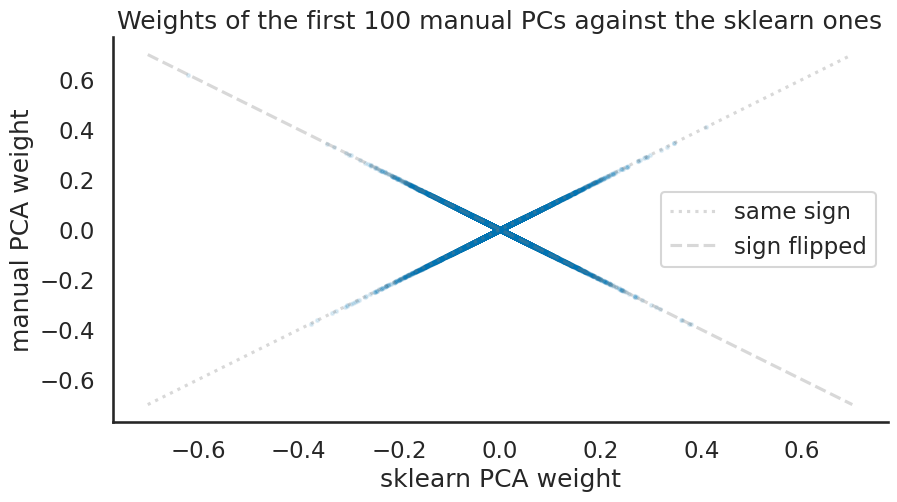

In [76]:
n_evs_to_compare = 100

plt.figure(figsize=(12, 5))
plt.scatter(PCs_sklearn[:, :n_evs_to_compare].flatten(),
            PCs[:, :n_evs_to_compare].flatten(), s=5, alpha=0.1)
plt.plot([-.7, .7], [-.7, .7], ':', c='tab:gray', label='same sign', alpha=0.3)
plt.plot([-.7, .7], [.7, -.7], '--', c='tab:gray', label='sign flipped', alpha=0.3)
plt.legend()
plt.xlabel('sklearn PCA weight')
plt.ylabel('manual PCA weight')
plt.title('Weights of the first %u manual PCs against the sklearn ones' % (n_evs_to_compare))

sns.despine()

After observing the graph, we can see that the maual calculation of the PCs and the ones obtained from sklearn have almost same values. Thus, we can say that our manual calculation of PCs is correct. 

Additional reading about the sign of PCs: https://stats.stackexchange.com/questions/88880/does-the-sign-of-scores-or-of-loadings-in-pca-or-fa-have-a-meaning-may-i-revers

## Task 3: Nonlinear dimensionality reduction with t-SNE

In this task, you will use the nonlinear dimensionality reduction technique t-SNE and look at visualizations of the data set. Plot the result of default t-SNE with the original cluster colors. For this and the following tasks, use the PCs explaining 75% of the variance ```PCA_75_sklearn``` you computed above.

In [77]:
def plot_tsne(tsne_results, clusters=tasic_1k['clusters'], labels=['']):
    '''Plotting function for tsne results, creates one or multiple plots of tSNE-transformed data.
       If the clustering is the original one (default), original cluster colors will be used. Otherwise,
       colors will be a random permutation.

    input:
        tsne_results: (n, 2)-shaped array containing tSNE-transformed data or list of such arrays
                      (output of the fit_transform function of sklearn tSNE)
        clusters: (n,)-shaped array containing cluster labels or list of such arrays
        labels: optional, list of titles for the subplots
    '''

    if type(tsne_results) == list:  # make sure we can do both single and multiple plots and are flexible regarding input
        num_plots = len(tsne_results)
    else:
        num_plots = 1
        tsne_results = [tsne_results]
    if type(clusters) == list:
        num_clusters = len(clusters)
        num_plots = num_plots * num_clusters
        tsne_results = tsne_results * num_clusters
    else:
        clusters = [clusters] * num_plots

    if len(labels) == 1:
        labels = labels * num_plots

    n_clusters = len(np.unique(clusters))      # ensure a long enough color list even if we plot more than
    n_colors = len(tasic_1k['clusterColors'])  # the original number of clusters
    if n_clusters > n_colors:
        n_extra_colors = n_clusters - n_colors
        colors = np.concatenate((tasic_1k['clusterColors'], tasic_1k['clusterColors'][:n_extra_colors]))
    else:
        colors = tasic_1k['clusterColors']

    fig, ax = plt.subplots(num_plots, 1, figsize=(10, num_plots*10))
    if num_plots == 1:
        if not np.all(tasic_1k['clusters'] == clusters[0]):
            current_colors = np.random.permutation(colors)
        else:
            current_colors = colors
        ax.scatter(tsne_results[0][:, 0], tsne_results[0][:, 1], s=1, color=current_colors[clusters[0]])
        ax.set_title(labels[0])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_axis_off()
    else:
        for i in range(num_plots):
            if not np.all(tasic_1k['clusters'] == clusters[i]):
                current_colors = np.random.permutation(colors)
            else:
                current_colors = colors
            ax[i].scatter(tsne_results[i][:, 0], tsne_results[i][:, 1], s=1, color=current_colors[clusters[i]])
            ax[i].set_title(labels[i])
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_axis_off()

Run the following cells to set the random seed/random state, run t-SNE and plot the results.

In [86]:
# create and fit TSNE, the fitted data should be in tsne_results variable
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(PCA_75_sklearn)

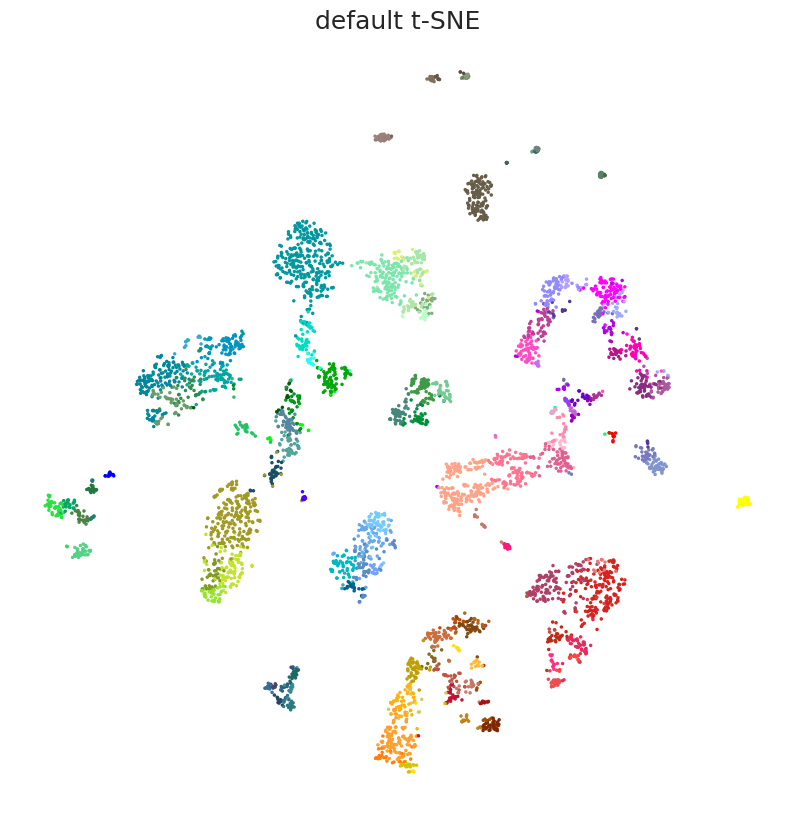

In [80]:
# Plotting

original_clusters = tasic_1k['clusters']
plot_tsne(tsne_results, original_clusters, labels=['default t-SNE'])

t-SNE has one main parameter called perplexity, which trades of local and global structure. Its default value is 30. Run the t-SNE with some other perplexity values (e.g. 5, 100), plot the results next to each other and explain what you observe. In particular, compare with the PCA plot above.

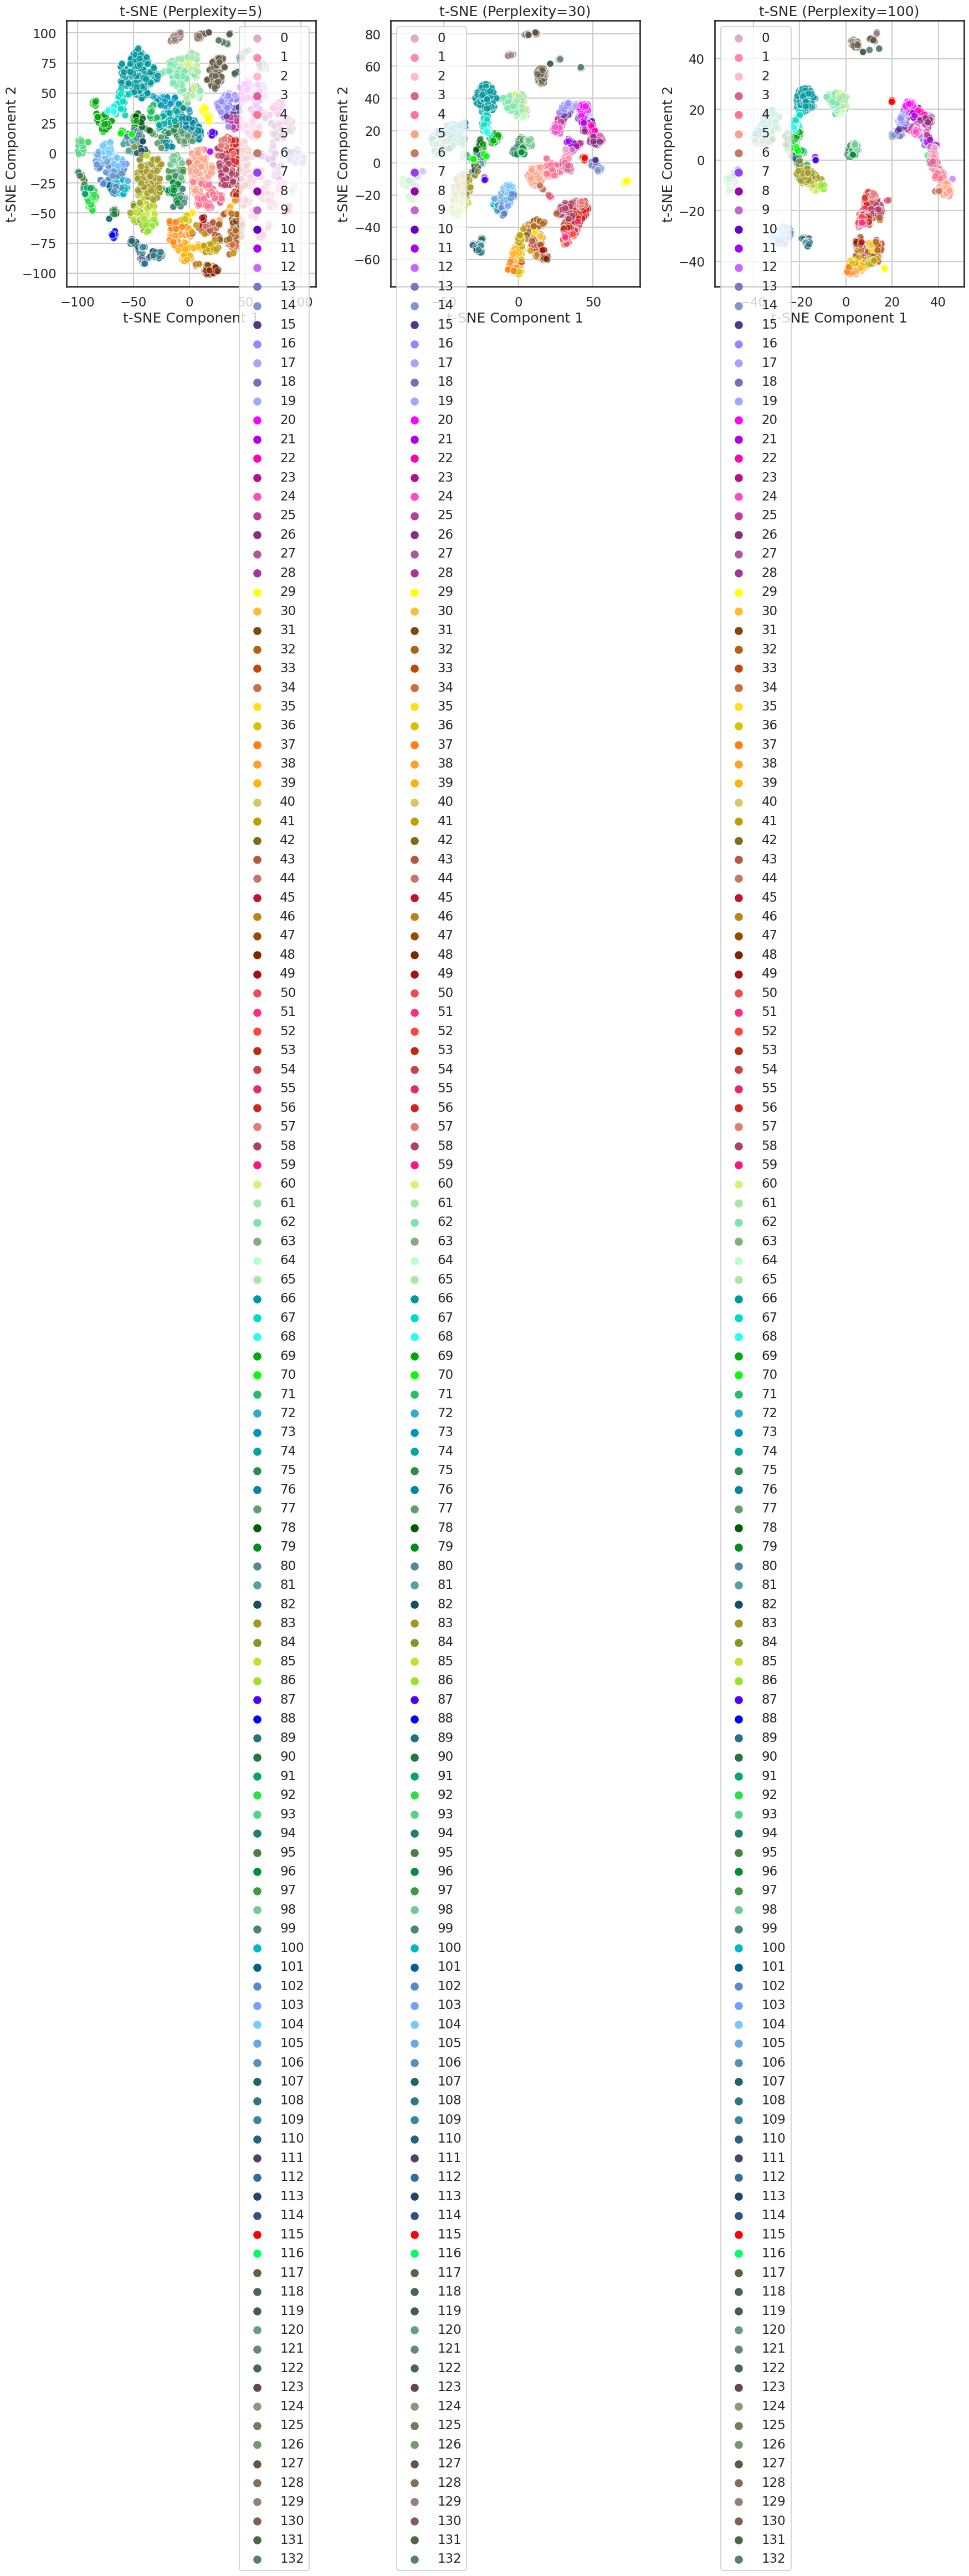

In [127]:
# Assuming PCA_75_sklearn is your PCA-reduced data explaining 75% variance
cluster_labels = tasic_1k['clusters']
cluster_colors = tasic_1k['clusterColors']

# Create a color palette dictionary
unique_clusters = np.unique(cluster_labels)
palette = {cluster: cluster_colors[i] for i, cluster in enumerate(unique_clusters)}

# Create t-SNE with different perplexity values
perplexities = [5, 30, 100]
tsne_results = {}

plt.figure(figsize=(18, 6))

# Loop over each perplexity value
for i, perplexity in enumerate(perplexities, 1):
    # Fit t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_results[perplexity] = tsne.fit_transform(PCA_75_sklearn)

    # Plotting
    plt.subplot(1, 3, i)
    sns.scatterplot(
        x=tsne_results[perplexity][:, 0], y=tsne_results[perplexity][:, 1], 
        hue=cluster_labels, palette=palette, 
        legend='full', alpha=0.7
    )
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title(f't-SNE (Perplexity={perplexity})')
    plt.grid(True)

# Adjust the space between subplots
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.3)

# Show the plot
plt.show()


Based on the plots, we can see that as we increase the values perplexity values, the cluster become more segregable in this context. 

Check out https://distill.pub/2016/misread-tsne/. There's a nice tool that let's you play with t-SNE parameters and visualize the consequences.